# Temp min max extractor

This min max extractor is to see the minimum and maximum temperature from each scenario

In [1]:
from source_ema.ema_climate_extractor import ClimateExtractor

ce = ClimateExtractor("input_ema/m1_gen_with_tasmax_overlay_BATCH_height_repl_202401-202412.csv")

# 1. Hitung MIN–MAX per provinsi
df = ce.compute_minmax()
ce.save("output_ema/1. temp/temperature_province_MINMAX_ASSETS.csv") #for provincial min-max

# 2. Hitung national temp 2051–2060 (RCP 8.5)
nat45 = ce.compute_national_temperature(scenario="45_2051_2060")
print(nat45)
nat85 = ce.compute_national_temperature(scenario="85_2051_2060")
print(nat85)


[OK] Saved climate min–max table to: output_ema/1. temp/temperature_province_MINMAX_ASSETS.csv
{'scenario': '45_2051_2060', 'national_min': 23.334, 'national_max': 37.095}
{'scenario': '85_2051_2060', 'national_min': 23.928, 'national_max': 37.907}


# Derating calculation

In [2]:
from source_ema.ema_derating_calculator import DeratingEngine

# 1. Load RUKN 2060
eng = DeratingEngine("data/ruptl_rukn/rukn_2060_Indonesia_capacity.csv")

# 2. Test Apply derating with manual input (example: 37.91°C)
df_result = eng.apply_derating(T_nat=37.91)

# 3. Summary nasional
summary = eng.summarize()
print(summary)


{'total_before_mw': np.int64(442600), 'total_after_mw': np.float64(425456.55), 'total_loss_mw': np.float64(17143.45), 'loss_percent': np.float64(3.87)}


# EMA WB initiation

In [3]:
from ema_workbench import Model, RealParameter, ScalarOutcome
from ema_workbench import perform_experiments
from source_ema.ema_derating_calculator import DeratingEngine

# === 1. INIT ENGINE ===
eng = DeratingEngine("data/ruptl_rukn/rukn_2060_Indonesia_capacity.csv")

# === 2. DEFINE EMA MODEL FUNCTION ===
def model_function(**experiment):
    Tnat = experiment["T_nat_2060"]   # uncertainty dari EMA

    # apply derating
    eng.apply_derating(Tnat)
    summary = eng.summarize()

    return {
        "loss_percent": summary["loss_percent"],
        "loss_mw": summary["total_loss_mw"],
    }

# === 3. CREATE MODEL WRAPPER ===
ema_model = Model("TemperatureDeratingTest", function=model_function)

# === 4. UNCERTAINTY SPACE ===
ema_model.uncertainties = [
    RealParameter("T_nat_2060", 22.93, 38.91)  # range dari Option2
]

# === 5. OUTCOMES ===
ema_model.outcomes = [
    ScalarOutcome("loss_percent"),
    ScalarOutcome("loss_mw")
]
experiments, outcomes = perform_experiments(ema_model, scenarios=1000)



100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 3755.29it/s]


## packing the output

In [4]:
import pandas as pd

df = pd.DataFrame({
    "T_nat": experiments["T_nat_2060"],
    "loss_percent": outcomes["loss_percent"],
    "loss_mw": outcomes["loss_mw"],
})

df.head()


,T_nat,loss_percent,loss_mw
0,37.463016,3.76,16646.64
1,28.869522,1.60,7095.32
2,30.397649,1.99,8793.77
3,26.906194,1.11,4913.16
4,31.200370,2.19,9685.96


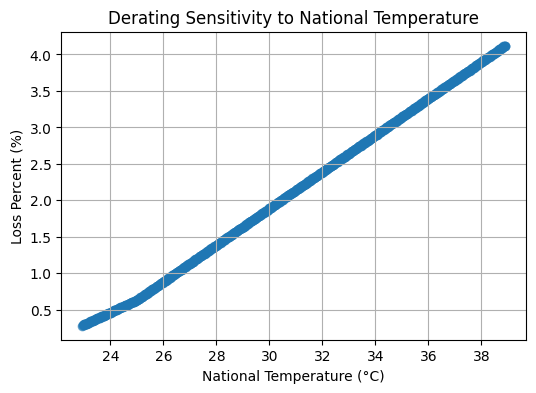

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(df["T_nat"], df["loss_percent"], alpha=0.6)
plt.xlabel("National Temperature (°C)")
plt.ylabel("Loss Percent (%)")
plt.title("Derating Sensitivity to National Temperature")
plt.grid(True)
plt.show()


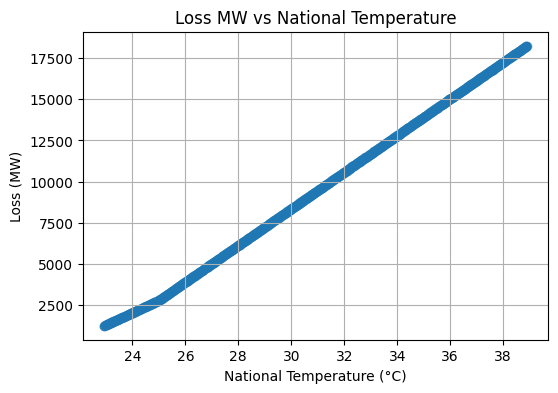

In [6]:
plt.figure(figsize=(6,4))
plt.scatter(df["T_nat"], df["loss_mw"], alpha=0.6)
plt.xlabel("National Temperature (°C)")
plt.ylabel("Loss (MW)")
plt.title("Loss MW vs National Temperature")
plt.grid(True)
plt.show()


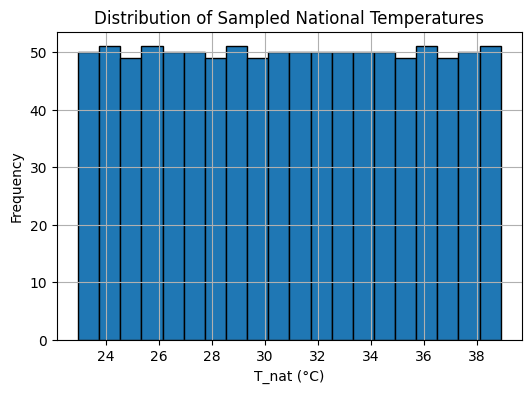

In [7]:
plt.figure(figsize=(6,4))
plt.hist(df["T_nat"], bins=20, edgecolor='black')
plt.xlabel("T_nat (°C)")
plt.ylabel("Frequency")
plt.title("Distribution of Sampled National Temperatures")
plt.grid(True)
plt.show()
